# Aggregate geo raster data on regions
Geographic (number) data is often published in a raster format (as a bitmap) that is tied to a specific coordinate system. One reason is the size of the data and a bitmap being a memory efficient and easily compressible data form. We learn how to bring such raster data in line with vectorized geographic data, by aggregating population raster data on administrative regions of Germany.

In [1]:
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pop1k_path = './data/GHS_BUILT_LDS1975_GLOBE_R2016A_54009_1k_v1_0/GHS_BUILT_LDS1975_GLOBE_R2016A_54009_1k_v1_0.tif'
germany_path = 'data/vg1000-ew_3112.utm32s.shape.ebenen/vg1000-ew_ebenen/VG1000_KRS.shp'

### load raster and shape data and adapt shape coordinate system to raster data
The other way around, adapting raster coordinates to shape coordinates is hard/stupid.
The shape data 'Verwaltungsgebiete mit Einwohnerzahlen is taken from Bundesamt für Kartographie und Geodäsie (© GeoBasis-DE / BKG 2019 http://www.bkg.bund.de)

In [3]:
pop1k_raster = rasterio.open(pop1k_path)
germany_shapes = gpd.read_file(germany_path)
germany_shapes.geometry = germany_shapes.geometry.to_crs(pop1k_raster.crs)

In [4]:
germany_shapes.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,KFL,DEBKG_ID,geometry
0,4,4,1,01001,01001,010010000000,Flensburg,Kreisfreie Stadt,40,--,...,000,R,DEF01,010010000000,01001000,2008-01-01,88519,56.73,DEBKGDL1000055UK,"POLYGON ((669629.9831432796 6367509.079648409,..."
1,4,4,1,01002,01002,010020000000,Kiel,Kreisfreie Stadt,40,--,...,000,R,DEF02,010020000000,01002000,2006-01-01,247943,118.65,DEBKGDL1000055TK,"POLYGON ((727772.4023377186 6327326.860408326,..."
2,4,4,1,01003,01003,010030000000,LÃ¼beck,Kreisfreie Stadt,40,--,...,000,R,DEF03,010030000000,01003000,2006-02-01,216318,214.19,DEBKGDL1000055W1,"POLYGON ((782907.1794287879 6281609.314016513,..."
3,4,4,1,01004,01004,010040000000,NeumÃ¼nster,Kreisfreie Stadt,40,--,...,000,R,DEF04,010040000000,01004000,1970-04-26,79335,71.66,DEBKGDL10000560Q,"POLYGON ((718793.1448090975 6299897.373177296,..."
4,4,4,1,01051,01051,010510044044,Dithmarschen,Kreis,42,--,...,000,R,DEF05,010510000000,01051000,2011-08-01,133447,1428.18,DEBKGDL10000563M,"(POLYGON ((648411.9130714792 6322389.60719121,..."


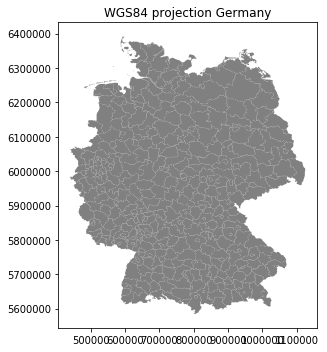

In [5]:
# Plot the WGS84
germany_shapes.plot(facecolor='gray', figsize=(5,5));

# Add title
plt.title("WGS84 projection Germany");
plt.tight_layout()

In [6]:
germany_shape = germany_shapes.dissolve(by='ADE')  # just some column with a constant value
ger_pop1k, ger_transform = rasterio.mask.mask(
    pop1k_raster, shapes=germany_shape.geometry, crop=True)
ger_pop1k_meta = pop1k_raster.meta.copy()
ger_pop1k_meta.update({
    "driver": "GTiff",
    "height": ger_pop1k.shape[1],
    "width": ger_pop1k.shape[2],
    "transform": ger_transform,
})
ger_pop1k[ger_pop1k < 0 ] = np.nan

### original raster data

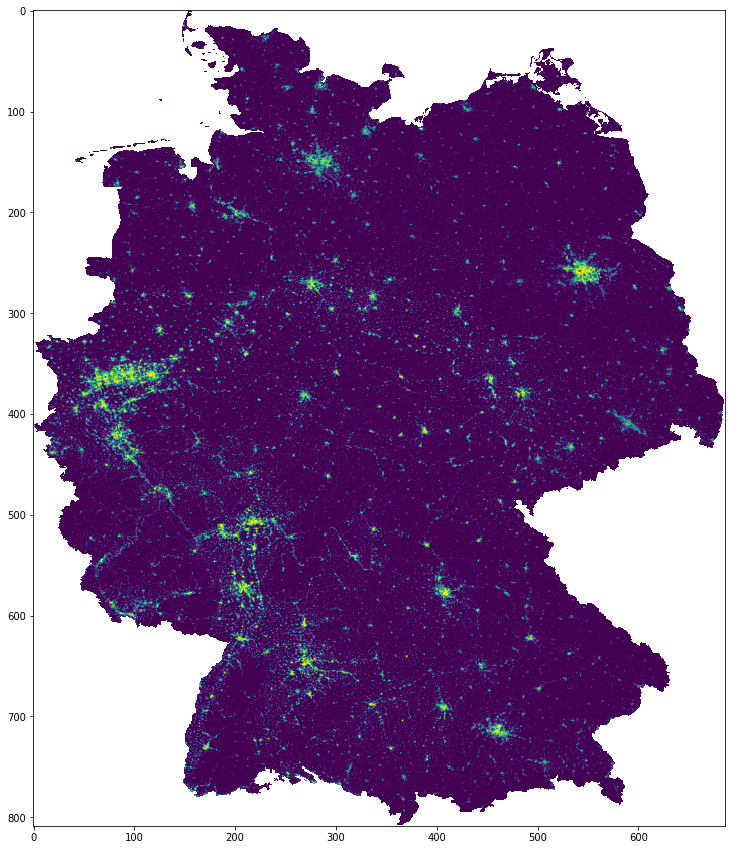

In [7]:
plt.figure(figsize=(15,15))
rasterio.plot.show(rasterio.plot.adjust_band(ger_pop1k))
plt.show()

## aggregate over municipalities

In [8]:
def population(shapes):
    patch, trans = rasterio.mask.mask(pop1k_raster, shapes=shapes, crop=True)
    return np.maximum(patch, 0).sum()

compare summing inside or outside rasterio

In [9]:
print(population(germany_shapes.geometry))
print(sum(population([germany_shapes.iloc[i].geometry]) for i in range(len(germany_shapes))))

14539.63
14539.62724977349


### population count per region

In [10]:
germany_shapes['population'] = germany_shapes.geometry.apply(lambda sh: population([sh]))

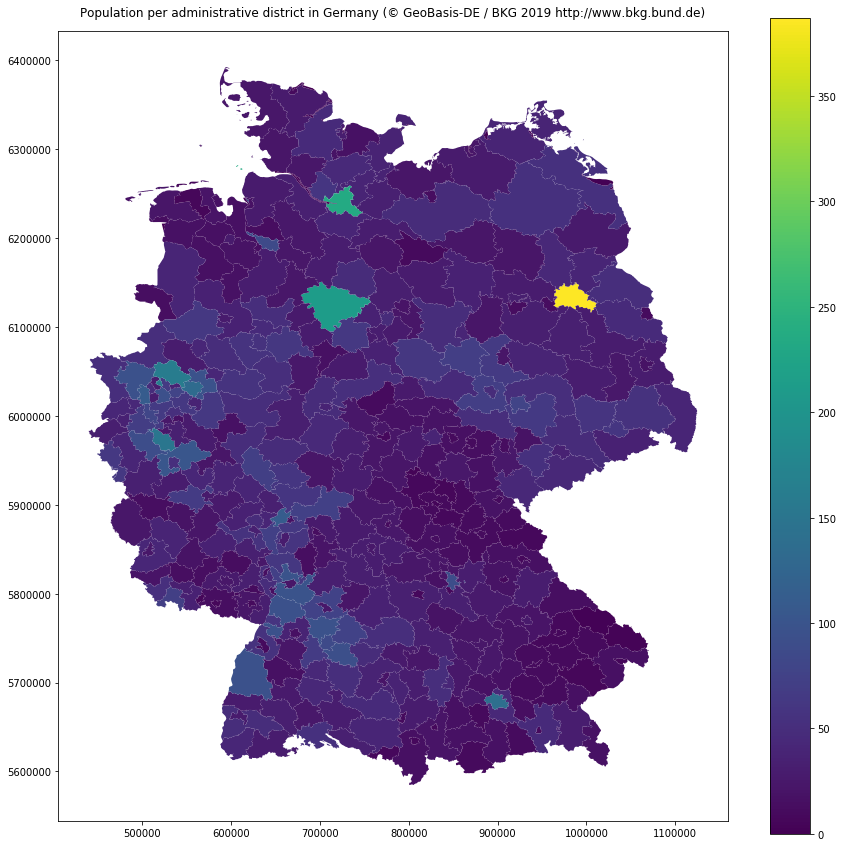

In [11]:
germany_shapes.plot(figsize=(15,15), column = "population", legend=True)
_ = plt.title('Population per administrative district in Germany (© GeoBasis-DE / BKG 2019 http://www.bkg.bund.de)',
             pad=15)

In [12]:
germany_shapes['area'] = germany_shapes.geometry.to_crs({'init': 'epsg:3395'}).map(lambda sh: sh.area / 1e6)
germany_shapes['population_density'] = germany_shapes['population'] / germany_shapes['area']

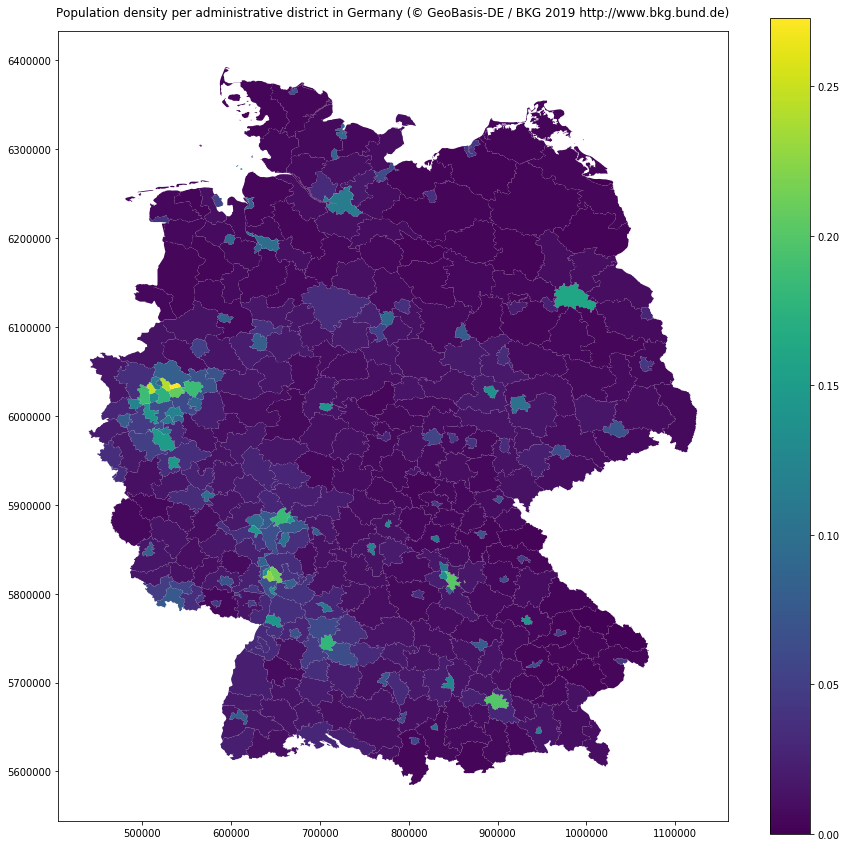

In [13]:
germany_shapes.plot(figsize=(15,15), column = "population_density", legend=True)
_ = plt.title('Population density per administrative district in Germany (© GeoBasis-DE / BKG 2019 http://www.bkg.bund.de)',
             pad=15)